In [1]:
#Import all the necessary python libraries
import os
import pandas as pd
import numpy as np

import json
import pymzml
import csv
import re
from tqdm import tqdm

import warnings

import plotly.graph_objs as go
from scipy.integrate import trapz
import matplotlib.pyplot as plt
from sklearn.mixture import GaussianMixture


#######################################
### FIX AND DOUBLE CHECK LATER#######
#################################
#CLAW made directories 
import create_directory
import CLAW
import OzESI_CLAW
# import OzESI
# import OzESI_plot
# import OzESI_compare

#version 2
import OzESI
from OzESI_plot import Plot
# Import the create_folder function from OzESI_utils
from OzESI_utils import create_folder, create_base_directory, generate_filename, save_for_ozone_compare, create_project_folder, filter_o3mzml_files, create_all_folders
from OzESI_compare import OzoneCompare

# Suppress all warnings
warnings.simplefilter(action='ignore', category=FutureWarning)



# Set Directories to load and save

In [2]:


# Define the mode: 'ON' or 'OFF'
mode = 'ON'  # Change to 'ON' as needed

# Project Directory
project = './Projects/'

# Project Name
project_name = 'AMP' #name of project
project_data_name = 'AMP' #name of data from project

project_folder_data = f'{project}{project_name}/AMP_ON/'
project_results_folder = f'{project}{project_name}/results/'

#mzML Data
mzml_data = f'{project}{project_name}/mzml/AMP_ON/' #mzML Parse

#CSV Data
csv_data_folder = f'{project_results_folder}csv_data/'


grouped_data_csv = f"{csv_data_folder}{project_data_name}_LipidGrouper_{mode}.csv" # Save RawDataParser output CSV file
matched_data_csv = f"{csv_data_folder}{project_data_name}_MatchedData_{mode}.csv" # Save MatchedData output CSV file
peak_analysis_csv = f"{csv_data_folder}{project_data_name}_PeakAnalysis_{mode}.csv" # Path to the PeakAnalysis output CSV file


#plot data
plots_directory = f'Projects/{project_name}/results/{project_data_name}/plots/on/'

#Database Locations
OzON_database = 'lipid_database/OzON_databases/OzON_Possible_Database.csv' ##double check this is right
OzOFF_database = f'{csv_data_folder}{project_name}_OzOFF_possible.csv'



# Define all necessary folder paths
folders_to_create = [
    csv_data_folder,
    plots_directory,
    project_results_folder,
    plots_directory
]

# Call the function to ensure all folders exist
create_all_folders(*folders_to_create)



Folder already exists: ./Projects/AMP/results/csv_data/
Folder already exists: Projects/AMP/results/AMP/plots/on/
Folder already exists: ./Projects/AMP/results/
Folder already exists: Projects/AMP/results/AMP/plots/on/


### MZML PARSER run on backend 
Step 1

In [12]:
# Submit the SLURM job for mzml_parser_1.sh
!sbatch core/backend/mzml_parser_1.sh


Submitted batch job 18287816


In [6]:
transition_summed_df = pd.read_csv('transition_summed_df.csv')
transition_summed_df.head()

,Parent_Ion,Product_Ion,Intensity,Transition,Sample_ID
0,227.1,183.0,128625.429199,227.1 -> 183.0,11162023_Blank-AMP_2x_MRMs_O3on_01
1,241.1,183.0,94654.506634,241.1 -> 183.0,11162023_Blank-AMP_2x_MRMs_O3on_01
2,255.2,183.0,160096.651577,255.2 -> 183.0,11162023_Blank-AMP_2x_MRMs_O3on_01
3,269.1,183.0,149254.590614,269.1 -> 183.0,11162023_Blank-AMP_2x_MRMs_O3on_01
4,283.2,183.0,479790.393131,283.2 -> 183.0,11162023_Blank-AMP_2x_MRMs_O3on_01


In [4]:
OzESI_df = pd.read_csv('OzESI_df.csv')
OzESI_df

,Lipid,Parent_Ion,Product_Ion,Retention_Time,OzESI_Intensity,Sample_ID,Transition
0,NaN,227.1,183.0,0.011583,40.640003,11162023_Blank-AMP_2x_MRMs_O3on_01,227.1 -> 183.0
1,NaN,227.1,183.0,0.024483,40.680004,11162023_Blank-AMP_2x_MRMs_O3on_01,227.1 -> 183.0
2,NaN,227.1,183.0,0.037383,40.640003,11162023_Blank-AMP_2x_MRMs_O3on_01,227.1 -> 183.0
3,NaN,227.1,183.0,0.050317,40.640003,11162023_Blank-AMP_2x_MRMs_O3on_01,227.1 -> 183.0
4,NaN,227.1,183.0,0.063233,40.640003,11162023_Blank-AMP_2x_MRMs_O3on_01,227.1 -> 183.0
...,...,...,...,...,...,...,...
5121228,NaN,533.5,183.0,29.949033,41.620003,11192023_5xFAD-m2-hippo-FAD257_AMP_2x_0.05uMd2...,533.5 -> 183.0
5121229,NaN,533.5,183.0,29.961967,41.600002,11192023_5xFAD-m2-hippo-FAD257_AMP_2x_0.05uMd2...,533.5 -> 183.0
5121230,NaN,533.5,183.0,29.974883,41.540005,11192023_5xFAD-m2-hippo-FAD257_AMP_2x_0.05uMd2...,533.5 -> 183.0
5121231,NaN,533.5,183.0,29.987800,41.480003,11192023_5xFAD-m2-hippo-FAD257_AMP_2x_0.05uMd2...,533.5 -> 183.0


# Import the 3 DFs A = OzOFF possibile, B = OzON Database, C = OzON Data

In [30]:
import pandas as pd

# # Import CSV files
OzOFF_database = pd.read_csv('Projects/AMP/results/csv_data/OzOFF_Possible_species.csv')
OzOFF_database = OzOFF_database.iloc[1000:1005]  # Keep only 5 rows for development

# OzON_database = pd.read_csv('lipid_database/OzON_databases/OzON_Possible_Database_0.csv')

# # Save as parquet files with the same names and directories
OzOFF_database.to_parquet('Projects/AMP/results/csv_data/OzOFF_Possible_species.parquet')
# OzON_database.to_parquet('lipid_database/OzON_databases/OzON_Possible_Database_0.parquet')

# Note: The OzESI_df is not used in this code as per your instructions

import pandas as pd

# Import parquet files
OzOFF_database = pd.read_parquet('Projects/AMP/results/csv_data/OzOFF_Possible_species.parquet')
# OzOFF_database = OzOFF_database.iloc[1000:1005]  # Keep only 5 rows for development
OzOFF_database.to_parquet('Projects/AMP/results/csv_data/OzOFF_Possible_species.parquet')

OzOFF_database = pd.read_parquet('Projects/AMP/results/csv_data/OzOFF_Possible_species.parquet')

OzON_database = pd.read_parquet('lipid_database/OzON_databases/OzON_Possible_Database_0.parquet')

# Note: The OzESI_df is not used in this code as per your instructions

In [31]:
# Assuming OzOFF_database is your DataFrame
# Display the first few rows of OzOFF_database
print(OzOFF_database.head())

# Keep only the first 5 rows
################ DO THIS TO MAKE DEVELOP GO MUST FASTER, REMOVE AFTER DEVELOPMENT DONE
# OzOFF_database = OzOFF_database.iloc[:21]

# Display the updated DataFrame to verify
OzOFF_database #A


                                              Sample_ID Lipid  Retention_Time  \
1000  11192023_5xFAD-m1-dienc-FAD249_AMP_2x_0.05uMd2...  18:1            8.66   
1001  11192023_5xFAD-m1-dienc-FAD249_AMP_2x_0.05uMd2...  18:2            7.51   
1002  11192023_5xFAD-m1-dienc-FAD249_AMP_2x_0.05uMd2...  18:3            4.13   
1003  11192023_5xFAD-m1-dienc-FAD249_AMP_2x_0.05uMd2...  19:0           11.06   
1004  11192023_5xFAD-m1-dienc-FAD249_AMP_2x_0.05uMd2...  20:0           12.01   

     Species  OzESI_Intensity                 Sample  Retention_Time_Median  
1000    18:1     1.280246e+06  dienc_5xFAD_m1_FAD249                   8.66  
1001    18:2     1.821452e+05  dienc_5xFAD_m1_FAD249                   7.51  
1002    18:3     1.182120e+04  dienc_5xFAD_m1_FAD249                   4.13  
1003    19:0     1.682866e+04  dienc_5xFAD_m1_FAD249                  11.06  
1004    20:0     8.759073e+04  dienc_5xFAD_m1_FAD249                  12.02  


,Sample_ID,Lipid,Retention_Time,Species,OzESI_Intensity,Sample,Retention_Time_Median
1000,11192023_5xFAD-m1-dienc-FAD249_AMP_2x_0.05uMd2...,18:1,8.66,18:1,1.280246e+06,dienc_5xFAD_m1_FAD249,8.66
1001,11192023_5xFAD-m1-dienc-FAD249_AMP_2x_0.05uMd2...,18:2,7.51,18:2,1.821452e+05,dienc_5xFAD_m1_FAD249,7.51
1002,11192023_5xFAD-m1-dienc-FAD249_AMP_2x_0.05uMd2...,18:3,4.13,18:3,1.182120e+04,dienc_5xFAD_m1_FAD249,4.13
1003,11192023_5xFAD-m1-dienc-FAD249_AMP_2x_0.05uMd2...,19:0,11.06,19:0,1.682866e+04,dienc_5xFAD_m1_FAD249,11.06
1004,11192023_5xFAD-m1-dienc-FAD249_AMP_2x_0.05uMd2...,20:0,12.01,20:0,8.759073e+04,dienc_5xFAD_m1_FAD249,12.02


In [13]:
OzON_database #B

,Lipid,Parent_Ion,Product_Ion,Species,Class,DB Location,FA mass,[FA+AMP]+
0,FA(5:0),269.3,183.0,5:0,FA,NaN,102.2,281.3
1,FA(6:0),283.3,183.0,6:0,FA,NaN,116.2,295.3
2,FA(6:1)_<>_n-2,269.2,183.0,6:1,FA,<>,114.1,281.2
3,FA(6:1)_<>_n-3,255.2,183.0,6:1,FA,<>,114.1,281.2
4,FA(6:1)_<>_n-4,241.2,183.0,6:1,FA,<>,114.1,281.2
...,...,...,...,...,...,...,...,...
6531,FA(30:6)_<BBFFF>_n-26,265.5,183.0,30:6,FA,<BBFFF>,440.4,607.5
6532,FA(30:6)_<FFFFF>_n-27,255.5,183.0,30:6,FA,<FFFFF>,440.4,607.5
6533,FA(30:6)_<BFFFF>_n-27,253.5,183.0,30:6,FA,<BFFFF>,440.4,607.5
6534,FA(30:6)_<FFFFF>_n-28,241.5,183.0,30:6,FA,<FFFFF>,440.4,607.5


In [14]:
OzESI_df #C

,Lipid,Parent_Ion,Product_Ion,Retention_Time,OzESI_Intensity,Sample_ID,Transition
0,NaN,227.1,183.0,0.011583,40.640003,11162023_Blank-AMP_2x_MRMs_O3on_01,227.1 -> 183.0
1,NaN,227.1,183.0,0.024483,40.680004,11162023_Blank-AMP_2x_MRMs_O3on_01,227.1 -> 183.0
2,NaN,227.1,183.0,0.037383,40.640003,11162023_Blank-AMP_2x_MRMs_O3on_01,227.1 -> 183.0
3,NaN,227.1,183.0,0.050317,40.640003,11162023_Blank-AMP_2x_MRMs_O3on_01,227.1 -> 183.0
4,NaN,227.1,183.0,0.063233,40.640003,11162023_Blank-AMP_2x_MRMs_O3on_01,227.1 -> 183.0
...,...,...,...,...,...,...,...
5121228,NaN,533.5,183.0,29.949033,41.620003,11192023_5xFAD-m2-hippo-FAD257_AMP_2x_0.05uMd2...,533.5 -> 183.0
5121229,NaN,533.5,183.0,29.961967,41.600002,11192023_5xFAD-m2-hippo-FAD257_AMP_2x_0.05uMd2...,533.5 -> 183.0
5121230,NaN,533.5,183.0,29.974883,41.540005,11192023_5xFAD-m2-hippo-FAD257_AMP_2x_0.05uMd2...,533.5 -> 183.0
5121231,NaN,533.5,183.0,29.987800,41.480003,11192023_5xFAD-m2-hippo-FAD257_AMP_2x_0.05uMd2...,533.5 -> 183.0


# Add Sample Column to OzESI_df

# Sample run on backend
step 2

In [14]:
# Submit the SLURM job for !sbatch core/backend/sample_2.sh
!sbatch core/backend/sample_2.sh


Submitted batch job 18287887


# MATCH LIPIDS

# match lipids with median RT

# run Match lipid on backend
step 3

In [32]:
# Submit the SLURM job for !sbatch core/backend/match_3.sh
!sbatch core/backend/match_3.sh


Submitted batch job 18292878


# Lipid group Class with sorting now

# LipidGrouper group lipids by ion m/z and samples
step 4

In [59]:
!sbatch core/backend/group_4.sh

Submitted batch job 18293233


In [61]:
# read in group_4.parquet data
group_4 = pd.read_parquet('df_group_4.parquet')
#print unique columns
print(group_4.columns.unique())
group_4

Index(['Lipid', 'Parent_Ion', 'Product_Ion', 'Retention_Time',
       'OzESI_Intensity', 'Sample_ID', 'Transition', 'Sample', 'Species',
       'Class', 'Possible_Lipids', 'Biology', 'Genotype', 'Cage', 'Mouse',
       'group_by_ion', 'group_by_lipid'],
      dtype='object')


,Lipid,Parent_Ion,Product_Ion,Retention_Time,OzESI_Intensity,Sample_ID,Transition,Sample,Species,Class,Possible_Lipids,Biology,Genotype,Cage,Mouse,group_by_ion,group_by_lipid
0,FA(18:1)_<>_n-10,325.2,183.0,8.162467,84.0,11162023_Blank-AMP_2x_MRMs_O3on_01,325.2 -> 183.0,Blank,18:1,FA,FA(18:1)_<>_n-10 | FA(18:2)_<F>_n-10 | FA(18:3...,,,,,336,0
1,FA(18:1)_<>_n-10,325.2,183.0,8.175400,91.0,11162023_Blank-AMP_2x_MRMs_O3on_01,325.2 -> 183.0,Blank,18:1,FA,FA(18:1)_<>_n-10 | FA(18:2)_<F>_n-10 | FA(18:3...,,,,,336,0
2,FA(18:1)_<>_n-10,325.2,183.0,8.188317,89.0,11162023_Blank-AMP_2x_MRMs_O3on_01,325.2 -> 183.0,Blank,18:1,FA,FA(18:1)_<>_n-10 | FA(18:2)_<F>_n-10 | FA(18:3...,,,,,336,0
3,FA(18:1)_<>_n-10,325.2,183.0,8.201233,81.0,11162023_Blank-AMP_2x_MRMs_O3on_01,325.2 -> 183.0,Blank,18:1,FA,FA(18:1)_<>_n-10 | FA(18:2)_<F>_n-10 | FA(18:3...,,,,,336,0
4,FA(18:1)_<>_n-10,325.2,183.0,8.214150,53.0,11162023_Blank-AMP_2x_MRMs_O3on_01,325.2 -> 183.0,Blank,18:1,FA,FA(18:1)_<>_n-10 | FA(18:2)_<F>_n-10 | FA(18:3...,,,,,336,0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
217849,FA(18:3)_<FF>_n-9,339.3,183.0,4.570200,310.0,11162023_WT-m5-hippo-FAD263_AMP_2x_0.05uMd216-...,339.3 -> 183.0,WT_m5_hippo_FAD263,18:3,FA,FA(18:1)_<>_n-9 | FA(18:2)_<F>_n-9 | FA(18:3)_...,hippo,WT,FAD263,m5,445,2746
217850,FA(18:3)_<FF>_n-9,339.3,183.0,4.583133,244.0,11162023_WT-m5-hippo-FAD263_AMP_2x_0.05uMd216-...,339.3 -> 183.0,WT_m5_hippo_FAD263,18:3,FA,FA(18:1)_<>_n-9 | FA(18:2)_<F>_n-9 | FA(18:3)_...,hippo,WT,FAD263,m5,445,2746
217851,FA(18:3)_<FF>_n-9,339.3,183.0,4.596050,174.0,11162023_WT-m5-hippo-FAD263_AMP_2x_0.05uMd216-...,339.3 -> 183.0,WT_m5_hippo_FAD263,18:3,FA,FA(18:1)_<>_n-9 | FA(18:2)_<F>_n-9 | FA(18:3)_...,hippo,WT,FAD263,m5,445,2746
217852,FA(18:3)_<FF>_n-9,339.3,183.0,4.608967,137.0,11162023_WT-m5-hippo-FAD263_AMP_2x_0.05uMd216-...,339.3 -> 183.0,WT_m5_hippo_FAD263,18:3,FA,FA(18:1)_<>_n-9 | FA(18:2)_<F>_n-9 | FA(18:3)_...,hippo,WT,FAD263,m5,445,2746


# after updated grouping ti should be sorted by RT

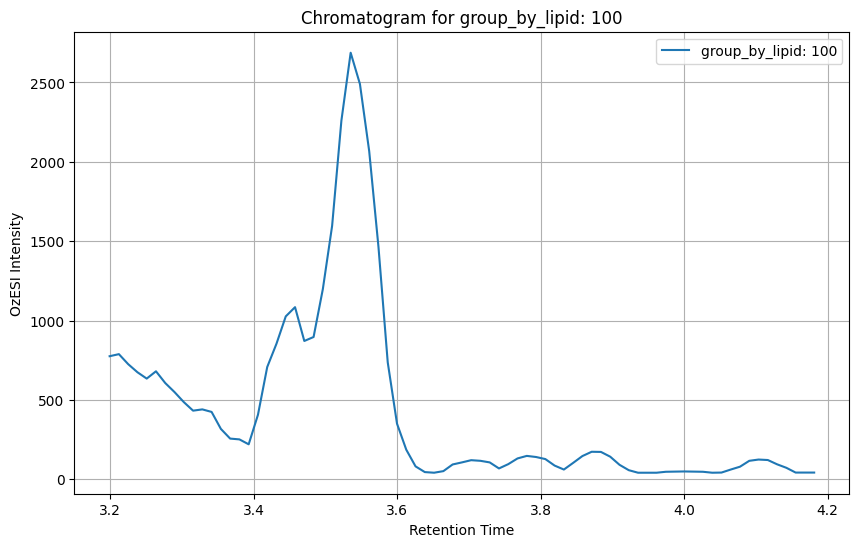

In [6]:
import matplotlib.pyplot as plt

# Function to plot the chromatogram for a specific group_by_lipid value
def plot_chromatogram(df, group_value):
    group_data = df[df['group_by_lipid'] == group_value]
    
    # Ensure the Retention_Time is sorted
    group_data = group_data.sort_values(by='Retention_Time')
    
    plt.figure(figsize=(10, 6))
    plt.plot(group_data['Retention_Time'], group_data['OzESI_Intensity'], label=f'group_by_lipid: {group_value}')
    plt.xlabel('Retention Time')
    plt.ylabel('OzESI Intensity')
    plt.title(f'Chromatogram for group_by_lipid: {group_value}')
    plt.legend()
    plt.grid(True)
    plt.show()

# Define the specific group_by_lipid value you are interested in
specific_group_by_lipid_value = 100  # Replace with the actual value you are interested in

# Call the function to plot the chromatogram
plot_chromatogram(df_grouped, specific_group_by_lipid_value)


# Lipid analysis after grouping

# Analysis 
step 5

In [21]:
!sbatch core/backend/analysis_5.sh

Submitted batch job 18293370


In [22]:
test_4 = pd.read_parquet('df_group_4.parquet')
#print unique columns 
print(test_4.columns.unique())
test_4

Index(['Lipid', 'Parent_Ion', 'Product_Ion', 'Retention_Time',
       'OzESI_Intensity', 'Sample_ID', 'Transition', 'Sample', 'Species',
       'Class', 'Possible_Lipids', 'Biology', 'Genotype', 'Cage', 'Mouse',
       'group_by_ion', 'group_by_lipid'],
      dtype='object')


,Lipid,Parent_Ion,Product_Ion,Retention_Time,OzESI_Intensity,Sample_ID,Transition,Sample,Species,Class,Possible_Lipids,Biology,Genotype,Cage,Mouse,group_by_ion,group_by_lipid
0,FA(18:1)_<>_n-10,325.2,183.0,8.162467,84.0,11162023_Blank-AMP_2x_MRMs_O3on_01,325.2 -> 183.0,Blank,18:1,FA,FA(18:1)_<>_n-10 | FA(18:2)_<F>_n-10 | FA(18:3...,,,,,336,0
1,FA(18:1)_<>_n-10,325.2,183.0,8.175400,91.0,11162023_Blank-AMP_2x_MRMs_O3on_01,325.2 -> 183.0,Blank,18:1,FA,FA(18:1)_<>_n-10 | FA(18:2)_<F>_n-10 | FA(18:3...,,,,,336,0
2,FA(18:1)_<>_n-10,325.2,183.0,8.188317,89.0,11162023_Blank-AMP_2x_MRMs_O3on_01,325.2 -> 183.0,Blank,18:1,FA,FA(18:1)_<>_n-10 | FA(18:2)_<F>_n-10 | FA(18:3...,,,,,336,0
3,FA(18:1)_<>_n-10,325.2,183.0,8.201233,81.0,11162023_Blank-AMP_2x_MRMs_O3on_01,325.2 -> 183.0,Blank,18:1,FA,FA(18:1)_<>_n-10 | FA(18:2)_<F>_n-10 | FA(18:3...,,,,,336,0
4,FA(18:1)_<>_n-10,325.2,183.0,8.214150,53.0,11162023_Blank-AMP_2x_MRMs_O3on_01,325.2 -> 183.0,Blank,18:1,FA,FA(18:1)_<>_n-10 | FA(18:2)_<F>_n-10 | FA(18:3...,,,,,336,0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
217849,FA(18:3)_<FF>_n-9,339.3,183.0,4.570200,310.0,11162023_WT-m5-hippo-FAD263_AMP_2x_0.05uMd216-...,339.3 -> 183.0,WT_m5_hippo_FAD263,18:3,FA,FA(18:1)_<>_n-9 | FA(18:2)_<F>_n-9 | FA(18:3)_...,hippo,WT,FAD263,m5,445,2746
217850,FA(18:3)_<FF>_n-9,339.3,183.0,4.583133,244.0,11162023_WT-m5-hippo-FAD263_AMP_2x_0.05uMd216-...,339.3 -> 183.0,WT_m5_hippo_FAD263,18:3,FA,FA(18:1)_<>_n-9 | FA(18:2)_<F>_n-9 | FA(18:3)_...,hippo,WT,FAD263,m5,445,2746
217851,FA(18:3)_<FF>_n-9,339.3,183.0,4.596050,174.0,11162023_WT-m5-hippo-FAD263_AMP_2x_0.05uMd216-...,339.3 -> 183.0,WT_m5_hippo_FAD263,18:3,FA,FA(18:1)_<>_n-9 | FA(18:2)_<F>_n-9 | FA(18:3)_...,hippo,WT,FAD263,m5,445,2746
217852,FA(18:3)_<FF>_n-9,339.3,183.0,4.608967,137.0,11162023_WT-m5-hippo-FAD263_AMP_2x_0.05uMd216-...,339.3 -> 183.0,WT_m5_hippo_FAD263,18:3,FA,FA(18:1)_<>_n-9 | FA(18:2)_<F>_n-9 | FA(18:3)_...,hippo,WT,FAD263,m5,445,2746


In [23]:
test_5 = pd.read_parquet('df_analysis_5.parquet')
#print unique columns
print(test_5.columns.unique())
test_5

Index(['Lipid', 'Retention_Time', 'OzESI_Intensity', 'group_by_ion',
       'group_by_lipid', 'Sample_ID', 'Transition', 'Sample', 'Parent_Ion',
       'Product_Ion', 'Species', 'Class', 'Possible_Lipids', 'Biology',
       'Genotype', 'Cage', 'Mouse', 'Peak_Height', 'FWHM', 'Peak_Width',
       'Peak_Area', 'Filter_Column'],
      dtype='object')


,Lipid,Retention_Time,OzESI_Intensity,group_by_ion,group_by_lipid,Sample_ID,Transition,Sample,Parent_Ion,Product_Ion,...,Possible_Lipids,Biology,Genotype,Cage,Mouse,Peak_Height,FWHM,Peak_Width,Peak_Area,Filter_Column
0,FA(18:1)_<>_n-2,8.480583,2077.0,1202,288,11192023_5xFAD-m1-cereb-FAD231_AMP_2x_0.05uMd2...,437.4 -> 183.0,5xFAD_m1_cereb_FAD231,437.4,183.0,...,FA(18:1)_<>_n-2 | FA(18:2)_<F>_n-2,cereb,5xFAD,FAD231,m1,2077.0,0.065651,0.064600,134.174200,group_by_lipid
1,FA(18:1)_<>_n-2,8.816517,115149.0,1202,288,11192023_5xFAD-m1-cereb-FAD231_AMP_2x_0.05uMd2...,437.4 -> 183.0,5xFAD_m1_cereb_FAD231,437.4,183.0,...,FA(18:1)_<>_n-2 | FA(18:2)_<F>_n-2,cereb,5xFAD,FAD231,m1,115149.0,0.120640,0.116283,13389.909550,group_by_lipid
2,FA(18:1)_<>_n-2,9.113683,132645.0,1202,288,11192023_5xFAD-m1-cereb-FAD231_AMP_2x_0.05uMd2...,437.4 -> 183.0,5xFAD_m1_cereb_FAD231,437.4,183.0,...,FA(18:1)_<>_n-2 | FA(18:2)_<F>_n-2,cereb,5xFAD,FAD231,m1,132645.0,0.044202,0.038767,5142.204500,group_by_lipid
3,FA(18:1)_<>_n-2,8.467650,9272.0,1203,289,11192023_5xFAD-m1-cereb-FAD249_AMP_2x_0.05uMd2...,437.4 -> 183.0,5xFAD_m1_cereb_FAD249,437.4,183.0,...,FA(18:1)_<>_n-2 | FA(18:2)_<F>_n-2,cereb,5xFAD,FAD249,m1,9272.0,0.088852,0.090433,838.497867,group_by_lipid
4,FA(18:1)_<>_n-2,8.751900,1519163.0,1203,289,11192023_5xFAD-m1-cereb-FAD249_AMP_2x_0.05uMd2...,437.4 -> 183.0,5xFAD_m1_cereb_FAD249,437.4,183.0,...,FA(18:1)_<>_n-2 | FA(18:2)_<F>_n-2,cereb,5xFAD,FAD249,m1,1519163.0,0.130759,0.129217,196301.178983,group_by_lipid
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
3001,FA(18:3)_<BF>_n-10,3.808500,1289.0,317,1834,11162023_WT-m5-dienc-FAD263_AMP_2x_0.05uMd216-...,323.2 -> 183.0,WT_m5_dienc_FAD263,323.2,183.0,...,FA(18:2)_<B>_n-10 | FA(18:3)_<BF>_n-10,dienc,WT,FAD263,m5,1289.0,0.049294,0.038767,49.970233,group_by_lipid
3002,FA(18:3)_<BF>_n-10,3.705167,3859.0,318,1843,11162023_WT-m5-hippo-FAD259_AMP_2x_0.05uMd216-...,323.2 -> 183.0,WT_m5_hippo_FAD259,323.2,183.0,...,FA(18:2)_<B>_n-10 | FA(18:3)_<BF>_n-10,hippo,WT,FAD259,m5,3859.0,0.057869,0.064600,249.291400,group_by_lipid
3003,FA(18:3)_<BF>_n-10,3.808533,1680.0,318,1843,11162023_WT-m5-hippo-FAD259_AMP_2x_0.05uMd216-...,323.2 -> 183.0,WT_m5_hippo_FAD259,323.2,183.0,...,FA(18:2)_<B>_n-10 | FA(18:3)_<BF>_n-10,hippo,WT,FAD259,m5,1680.0,0.049338,0.051683,86.828000,group_by_lipid
3004,FA(18:3)_<FF>_n-11,3.808717,1392.0,279,2216,11192023_5xFAD-m1-cereb-FAD249_AMP_2x_0.05uMd2...,311.3 -> 183.0,5xFAD_m1_cereb_FAD249,311.3,183.0,...,FA(18:1)_<>_n-11 | FA(18:2)_<F>_n-11 | FA(18:3...,cereb,5xFAD,FAD249,m1,1392.0,0.047919,0.051683,71.943200,group_by_lipid


In [25]:
test_5_sorted = pd.read_parquet('df_analysis_5_sorted.parquet')
#print unique columns
print(test_5_sorted.columns.unique())
test_5_sorted

Index(['Lipid', 'Retention_Time', 'OzESI_Intensity', 'group_by_ion',
       'group_by_lipid', 'Sample_ID', 'Transition', 'Sample', 'Parent_Ion',
       'Product_Ion', 'Species', 'Class', 'Possible_Lipids', 'Biology',
       'Genotype', 'Cage', 'Mouse', 'Peak_Height', 'FWHM', 'Peak_Width',
       'Peak_Area', 'Filter_Column'],
      dtype='object')


,Lipid,Retention_Time,OzESI_Intensity,group_by_ion,group_by_lipid,Sample_ID,Transition,Sample,Parent_Ion,Product_Ion,...,Possible_Lipids,Biology,Genotype,Cage,Mouse,Peak_Height,FWHM,Peak_Width,Peak_Area,Filter_Column
0,FA(18:1)_<>_n-2,8.480583,2077.0,1202,288,11192023_5xFAD-m1-cereb-FAD231_AMP_2x_0.05uMd2...,437.4 -> 183.0,5xFAD_m1_cereb_FAD231,437.4,183.0,...,FA(18:1)_<>_n-2 | FA(18:2)_<F>_n-2,cereb,5xFAD,FAD231,m1,2077.0,0.065651,0.064600,134.174200,group_by_lipid
1,FA(18:1)_<>_n-2,8.816517,115149.0,1202,288,11192023_5xFAD-m1-cereb-FAD231_AMP_2x_0.05uMd2...,437.4 -> 183.0,5xFAD_m1_cereb_FAD231,437.4,183.0,...,FA(18:1)_<>_n-2 | FA(18:2)_<F>_n-2,cereb,5xFAD,FAD231,m1,115149.0,0.120640,0.116283,13389.909550,group_by_lipid
2,FA(18:1)_<>_n-2,9.113683,132645.0,1202,288,11192023_5xFAD-m1-cereb-FAD231_AMP_2x_0.05uMd2...,437.4 -> 183.0,5xFAD_m1_cereb_FAD231,437.4,183.0,...,FA(18:1)_<>_n-2 | FA(18:2)_<F>_n-2,cereb,5xFAD,FAD231,m1,132645.0,0.044202,0.038767,5142.204500,group_by_lipid
3,FA(18:1)_<>_n-2,8.467650,9272.0,1203,289,11192023_5xFAD-m1-cereb-FAD249_AMP_2x_0.05uMd2...,437.4 -> 183.0,5xFAD_m1_cereb_FAD249,437.4,183.0,...,FA(18:1)_<>_n-2 | FA(18:2)_<F>_n-2,cereb,5xFAD,FAD249,m1,9272.0,0.088852,0.090433,838.497867,group_by_lipid
4,FA(18:1)_<>_n-2,8.751900,1519163.0,1203,289,11192023_5xFAD-m1-cereb-FAD249_AMP_2x_0.05uMd2...,437.4 -> 183.0,5xFAD_m1_cereb_FAD249,437.4,183.0,...,FA(18:1)_<>_n-2 | FA(18:2)_<F>_n-2,cereb,5xFAD,FAD249,m1,1519163.0,0.130759,0.129217,196301.178983,group_by_lipid
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
3001,FA(18:3)_<BF>_n-10,3.808500,1289.0,317,1834,11162023_WT-m5-dienc-FAD263_AMP_2x_0.05uMd216-...,323.2 -> 183.0,WT_m5_dienc_FAD263,323.2,183.0,...,FA(18:2)_<B>_n-10 | FA(18:3)_<BF>_n-10,dienc,WT,FAD263,m5,1289.0,0.049294,0.038767,49.970233,group_by_lipid
3002,FA(18:3)_<BF>_n-10,3.705167,3859.0,318,1843,11162023_WT-m5-hippo-FAD259_AMP_2x_0.05uMd216-...,323.2 -> 183.0,WT_m5_hippo_FAD259,323.2,183.0,...,FA(18:2)_<B>_n-10 | FA(18:3)_<BF>_n-10,hippo,WT,FAD259,m5,3859.0,0.057869,0.064600,249.291400,group_by_lipid
3003,FA(18:3)_<BF>_n-10,3.808533,1680.0,318,1843,11162023_WT-m5-hippo-FAD259_AMP_2x_0.05uMd216-...,323.2 -> 183.0,WT_m5_hippo_FAD259,323.2,183.0,...,FA(18:2)_<B>_n-10 | FA(18:3)_<BF>_n-10,hippo,WT,FAD259,m5,1680.0,0.049338,0.051683,86.828000,group_by_lipid
3004,FA(18:3)_<FF>_n-11,3.808717,1392.0,279,2216,11192023_5xFAD-m1-cereb-FAD249_AMP_2x_0.05uMd2...,311.3 -> 183.0,5xFAD_m1_cereb_FAD249,311.3,183.0,...,FA(18:1)_<>_n-11 | FA(18:2)_<F>_n-11 | FA(18:3...,cereb,5xFAD,FAD249,m1,1392.0,0.047919,0.051683,71.943200,group_by_lipid


# PLOT update

In [2]:
import os
import pandas as pd
import matplotlib.pyplot as plt
from scipy.signal import find_peaks, peak_widths

class Plot:
    def __init__(self, raw_data_file, analyzed_data_file):
        self.raw_data = pd.read_parquet(raw_data_file)
        self.analyzed_data = pd.read_parquet(analyzed_data_file)

    def plot_peaks(self, project_results=None, file_name_to_save=None):
        unique_lipids = self.analyzed_data['Lipid'].unique()

        for lipid in unique_lipids:
            lipid_data = self.analyzed_data[self.analyzed_data['Lipid'] == lipid]
            plt.figure(figsize=(10, 6))

            plt.plot(lipid_data['Retention_Time'], lipid_data['OzESI_Intensity'], label='Intensity')
            plt.scatter(lipid_data['Retention_Time'], lipid_data['OzESI_Intensity'], color='red')

            for _, row in lipid_data.iterrows():
                plt.annotate(f"Peak Height: {row['Peak_Height']:.2f}\nFWHM: {row['FWHM']:.2f}\nArea: {row['Peak_Area']:.2f}",
                             (row['Retention_Time'], row['OzESI_Intensity']),
                             textcoords="offset points",
                             xytext=(0, 10),
                             ha='center')

            plt.title(f"Peaks for Lipid: {lipid}")
            plt.xlabel('Retention Time')
            plt.ylabel('OzESI Intensity')
            plt.legend()
            plt.grid(True)

            if project_results and file_name_to_save:
                plot_folder = f'{project_results}plots/'
                os.makedirs(plot_folder, exist_ok=True)
                plt.savefig(f"{plot_folder}{file_name_to_save}_{lipid}_peaks.png")
            plt.show()
            plt.close()

    def plot_data_and_peaks(self, group_type, group_value, height=1000, width=None, rel_height=0.5):
        if group_type not in ['group_by_ion', 'group_by_lipid']:
            raise ValueError(f"group_type must be 'group_by_ion' or 'group_by_lipid'")

        if group_type not in self.raw_data.columns:
            raise ValueError(f"group_type '{group_type}' is not a valid column in the data")

        group_data = self.raw_data[self.raw_data[group_type] == group_value]
        peaks, properties = find_peaks(group_data['OzESI_Intensity'], height=height, width=width)
        results_half = peak_widths(group_data['OzESI_Intensity'], peaks, rel_height=rel_height)

        plt.figure(figsize=(10, 6))
        plt.plot(group_data['Retention_Time'], group_data['OzESI_Intensity'], label='Intensity')
        plt.scatter(group_data['Retention_Time'].iloc[peaks], group_data['OzESI_Intensity'].iloc[peaks], color='red')

        for i, peak in enumerate(peaks):
            left_ip = results_half[2][i]
            right_ip = results_half[3][i]
            left_time = group_data['Retention_Time'].iloc[int(left_ip)]
            right_time = group_data['Retention_Time'].iloc[int(right_ip)]
            width_in_time = right_time - left_time

            fwhm = results_half[0][i] * (group_data['Retention_Time'].values[1] - group_data['Retention_Time'].values[0])

            plt.annotate(
                f"Peak Height: {properties['peak_heights'][i]:.2f}\nFWHM: {fwhm:.2f}\nArea: {properties['peak_heights'][i] * width_in_time:.2f}",
                (group_data['Retention_Time'].iloc[peak], group_data['OzESI_Intensity'].iloc[peak]),
                textcoords="offset points",
                xytext=(0, 10),
                ha='center'
            )

        if group_type == 'group_by_lipid':
            lipid_value = group_data['Lipid'].iloc[0] if 'Lipid' in group_data.columns else 'Unknown'
            plot_title = f"Lipid: {lipid_value}"
        else:  # group_type == 'group_by_ion'
            parent_ion_value = group_data['Parent_Ion'].iloc[0] if 'Parent_Ion' in group_data.columns else 'Unknown'
            plot_title = f"Parent Ion: {parent_ion_value}"

        plt.title(f"Peaks for {plot_title}")
        plt.xlabel('Retention Time')
        plt.ylabel('OzESI Intensity')
        plt.legend()
        plt.grid(True)
        plt.show()

# Example usage:
# plotter = Plot("df_group_4.parquet", "df_analysis_5.parquet")
# plotter.plot_peaks(project_results="./results/", file_name_to_save="lipid_analysis")
# plotter.plot_data_and_peaks(group_type='group_by_lipid', group_value='some_group_value', height=1000, width=1, rel_height=0.5)


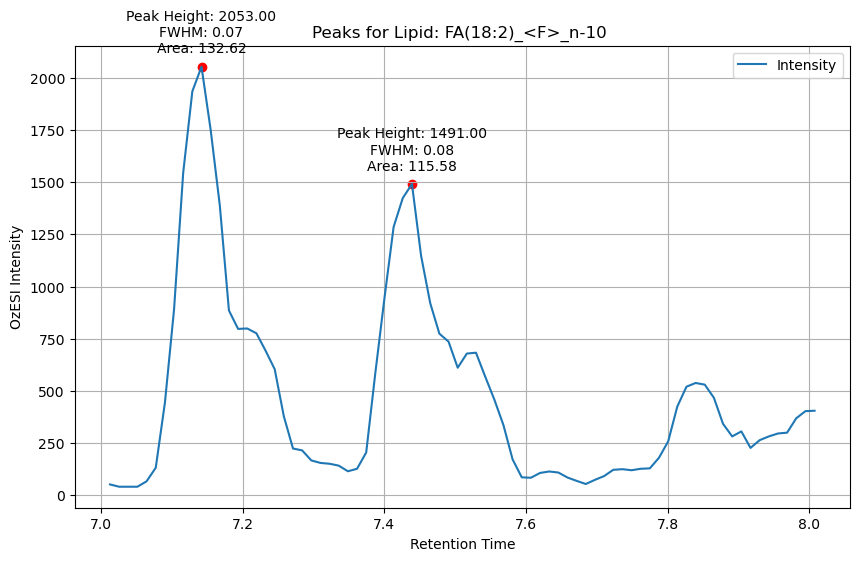

In [9]:
# Initialize the Plot class with the raw data and analyzed peaks files
plotter = Plot("df_group_4.parquet", "df_analysis_5.parquet")

# # Plot peaks for each lipid
# plotter.plot_peaks(project_results="./results/", file_name_to_save="lipid_analysis")

# Plot data and peaks for a specific group
group_type = 'group_by_lipid'  # or 'group_by_ion'
group_value = 1010  # Replace with the actual group value you want to plot
plotter.plot_data_and_peaks(group_type, group_value, height=1000, width=1, rel_height=0.5)


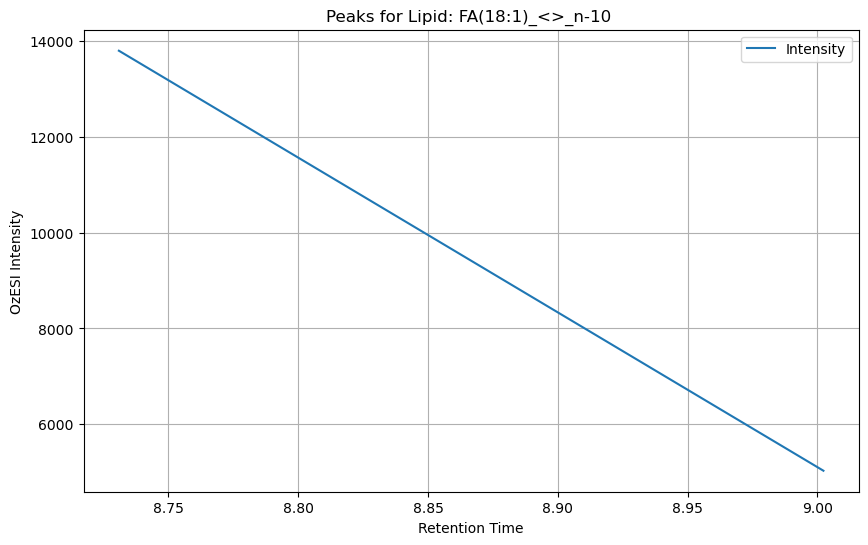

In [20]:
import pandas as pd
from core.python.analysis_5 import LipidAnalysis  # Assuming the class is in a file named lipid_analysis.py

# Load the analyzed data
df_analysis_5 = pd.read_parquet("df_analysis_5.parquet")

# Create an instance of LipidAnalysis with the loaded data
analysis = LipidAnalysis(df_analysis_5)

# Parameters for plotting
group_type = 'group_by_lipid'  # or 'group_by_ion' based on your requirement
group_value = 22  # Replace with the actual group value you want to plot
height = 1000
width = 1
rel_height = 0.5

# Call the plot_data_and_peaks function
analysis.plot_data_and_peaks(group_type, group_value, height, width, rel_height)


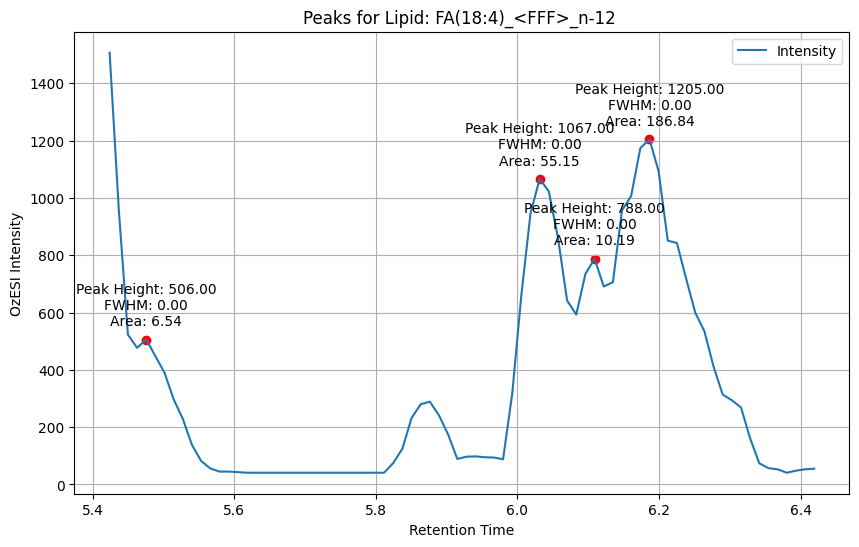

In [13]:

analysis.plot_data_and_peaks(group_type='group_by_lipid', group_value=437, height=500, width=2, rel_height=0.5)

In [15]:
peaks_df

,Lipid,group_by_lipid,Sample,Retention_Time,OzESI_Intensity,group_by_ion,Sample_ID,Transition,Parent_Ion,Product_Ion,...,Possible_Lipids,Biology,Genotype,Cage,Mouse,Peak_Height,FWHM,Peak_Width,Peak_Area,Filter_Column
446,FA(8:1)_<>_n-2,858,WT_m1_cereb_FAD245,3.344000,10529.0,8,11162023_WT-m1-cereb-FAD245_AMP_2x_0.05uMd216-...,297.2 -> 183.0,297.2,183.0,...,FA(7:0) | FA(8:1)_<>_n-2 | FA(9:1)_<>_n-3 | FA...,cereb,WT,FAD245,m1,10529.0,0.0,0.064617,680.348883,group_by_lipid
447,FA(8:1)_<>_n-2,859,WT_m1_cortex_FAD245,3.343983,12221.0,9,11162023_WT-m1-cortex-FAD245_AMP_2x_0.05uMd216...,297.2 -> 183.0,297.2,183.0,...,FA(7:0) | FA(8:1)_<>_n-2 | FA(9:1)_<>_n-3 | FA...,cortex,WT,FAD245,m1,12221.0,0.0,0.064600,789.476600,group_by_lipid
448,FA(9:1)_<>_n-2,868,WT_m1_cereb_FAD245,3.602000,50798.0,12,11162023_WT-m1-cereb-FAD245_AMP_2x_0.05uMd216-...,311.3 -> 183.0,311.3,183.0,...,FA(8:0) | FA(9:1)_<>_n-2 | FA(10:1)_<>_n-3 | F...,cereb,WT,FAD245,m1,50798.0,0.0,0.064600,3281.550800,group_by_lipid
449,FA(9:1)_<>_n-2,869,WT_m1_cortex_FAD245,3.601983,61497.0,13,11162023_WT-m1-cortex-FAD245_AMP_2x_0.05uMd216...,311.3 -> 183.0,311.3,183.0,...,FA(8:0) | FA(9:1)_<>_n-2 | FA(10:1)_<>_n-3 | F...,cortex,WT,FAD245,m1,61497.0,0.0,0.064600,3972.706200,group_by_lipid
450,FA(9:1)_<>_n-3,870,WT_m1_cereb_FAD245,3.344000,10529.0,8,11162023_WT-m1-cereb-FAD245_AMP_2x_0.05uMd216-...,297.2 -> 183.0,297.2,183.0,...,FA(7:0) | FA(8:1)_<>_n-2 | FA(9:1)_<>_n-3 | FA...,cereb,WT,FAD245,m1,10529.0,0.0,0.064617,680.348883,group_by_lipid
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
434,FA(22:6)_<FFFFF>_n-10,831,WT_m1_cortex_FAD245,5.718483,572.0,37,11162023_WT-m1-cortex-FAD245_AMP_2x_0.05uMd216...,381.3 -> 183.0,381.3,183.0,...,FA(13:0) | FA(14:1)_<>_n-2 | FA(15:1)_<>_n-3 |...,cortex,WT,FAD245,m1,572.0,0.0,0.025833,14.776667,group_by_lipid
428,FA(22:6)_<BFFFF>_n-10,811,WT_m1_cortex_FAD245,5.938333,303.0,35,11162023_WT-m1-cortex-FAD245_AMP_2x_0.05uMd216...,379.3 -> 183.0,379.3,183.0,...,FA(15:2)_<B>_n-3 | FA(15:3)_<BF>_n-3 | FA(16:2...,cortex,WT,FAD245,m1,303.0,0.0,0.064617,19.578850,group_by_lipid
435,FA(22:6)_<FFFFF>_n-11,832,WT_m1_cereb_FAD245,5.667433,345.0,30,11162023_WT-m1-cereb-FAD245_AMP_2x_0.05uMd216-...,367.3 -> 183.0,367.3,183.0,...,FA(12:0) | FA(13:1)_<>_n-2 | FA(14:1)_<>_n-3 |...,cereb,WT,FAD245,m1,345.0,0.0,0.064600,22.287000,group_by_lipid
436,FA(22:6)_<FFFFF>_n-13,837,WT_m1_cortex_FAD245,6.056050,428.0,21,11162023_WT-m1-cortex-FAD245_AMP_2x_0.05uMd216...,339.3 -> 183.0,339.3,183.0,...,FA(10:0) | FA(12:1)_<>_n-3 | FA(13:1)_<>_n-4 |...,cortex,WT,FAD245,m1,428.0,0.0,0.077517,33.177133,group_by_lipid


In [60]:
# Extract unique Lipid values
unique_lipids = peaks_df['Lipid'].unique()
print(unique_lipids)

# Create a new DataFrame with the unique Lipid values
unique_lipids_df = pd.DataFrame(unique_lipids, columns=['unique_lipids'])

unique_lipids_df.to_csv('AMP_unique_lipids_07jul24.csv', index=False)

['FA(8:1)_<>_n-2 ' 'FA(9:1)_<>_n-2 ' 'FA(9:1)_<>_n-3 ' 'FA(10:1)_<>_n-2 '
 'FA(10:1)_<>_n-3 ' 'FA(10:1)_<>_n-4 ' 'FA(12:1)_<>_n-2 '
 'FA(12:1)_<>_n-3 ' 'FA(12:1)_<>_n-4 ' 'FA(12:1)_<>_n-5 '
 'FA(12:1)_<>_n-6 ' 'FA(13:1)_<>_n-2 ' 'FA(13:1)_<>_n-3 '
 'FA(13:1)_<>_n-4 ' 'FA(13:1)_<>_n-5 ' 'FA(13:1)_<>_n-6 '
 'FA(13:1)_<>_n-7 ' 'FA(13:1)_<>_n-8 ' 'FA(14:1)_<>_n-2 '
 'FA(14:1)_<>_n-3 ' 'FA(14:1)_<>_n-4 ' 'FA(14:1)_<>_n-5 '
 'FA(14:1)_<>_n-6 ' 'FA(14:1)_<>_n-8 ' 'FA(15:1)_<>_n-2 '
 'FA(15:1)_<>_n-3 ' 'FA(15:1)_<>_n-4 ' 'FA(15:1)_<>_n-6 '
 'FA(15:1)_<>_n-9 ' 'FA(15:2)_<F>_n-2 ' 'FA(15:2)_<B>_n-2 '
 'FA(15:2)_<F>_n-3 ' 'FA(15:2)_<B>_n-3 ' 'FA(15:2)_<F>_n-4 '
 'FA(15:2)_<B>_n-4 ' 'FA(15:2)_<F>_n-5 ' 'FA(15:2)_<F>_n-6 '
 'FA(15:2)_<B>_n-6 ' 'FA(15:2)_<F>_n-7 ' 'FA(15:2)_<B>_n-7 '
 'FA(15:2)_<F>_n-8 ' 'FA(15:2)_<B>_n-8 ' 'FA(15:2)_<F>_n-9 '
 'FA(15:3)_<BF>_n-2 ' 'FA(15:3)_<FF>_n-3 ' 'FA(15:3)_<BF>_n-3 '
 'FA(15:3)_<BB>_n-3 ' 'FA(15:3)_<FF>_n-4 ' 'FA(15:3)_<BF>_n-4 '
 'FA(15:3)_<BB>_n-4 ' 'FA(15:3

# Plot

In [54]:
import matplotlib.pyplot as plt
import pandas as pd
from tqdm import tqdm

class Plot:
    def __init__(self, dataframe):
        self.dataframe = dataframe

    def scatter(self):
        """Create scatter plots of Peak_Area by Lipid for each unique Biology and save as PNG."""
        # Assuming dataframe is already loaded
        filtered_df = self.dataframe[self.dataframe['Peak_Area'] > 0].dropna(subset=['Peak_Area'])

        if filtered_df.empty:
            print("No lipids with peak areas found. Scatter plots will not be displayed.")
            return

        # Get unique Biology values
        biology_values = filtered_df['Biology'].unique()

        for biology in tqdm(biology_values, desc="Creating scatter plots"):
            biology_df = filtered_df[filtered_df['Biology'] == biology]
            grouped = biology_df.groupby('Lipid')
            
            # Debug: Print grouped data
            #for lipid, group in grouped:
                #print(f"Biology: {biology}, Lipid: {lipid}, Data Points: {len(group)}, Peak Areas: {group['Peak_Area'].tolist()}")

            fig, ax = plt.subplots(figsize=(14, 14))
            colors = plt.cm.tab20.colors * (len(grouped) // len(plt.cm.tab20.colors) + 1)

            for (key, group), color in zip(grouped, colors):
                ax.scatter(group['Lipid'], group['Peak_Area'], label=str(key), color=color, s=100)

            ax.set_xlabel('Lipid')
            ax.set_ylabel('Peak Area')
            ax.set_title(f'Peak Area by Lipid (Biology: {biology})')
            ax.set_xticks([i for i, _ in enumerate(grouped.groups.keys())])
            ax.set_xticklabels(grouped.groups.keys(), rotation='vertical')
            ax.legend(title='Sample', bbox_to_anchor=(1.05, 1), loc='upper left')
            
            # Save the figure as a PNG file
            filename = f'Peak_Area_by_Lipid_{biology}.png'
            plt.savefig(filename)
            plt.close(fig)

# Example usage
plotter = Plot(dataframe=peaks_df)
plotter.scatter()


Creating scatter plots: 100%|██████████| 2/2 [00:20<00:00, 10.19s/it]
